In [1]:
import sys
sys.path.append("../../code")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lhsmdu
from cosmosis.runtime.config import Inifile
from cosmosis.runtime.pipeline import LikelihoodPipeline
from george.kernels import LinearKernel, ExpSquaredKernel, Matern32Kernel
from george.modeling import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from itertools import product
import pickle
import numpy as np
import george
import matplotlib.pyplot as plt
import os
import sys
from contextlib import contextmanager
from astropy.table import Table
from astropy.io import fits


%matplotlib inline

In [2]:
data_dir  = '/home/pedro/Documents/mestrado/monografia-analise/data/emulator-simulated/'
plots_dir = '/home/pedro/Documents/mestrado/monografia-analise/plots/emulator-simulated/'

In [3]:
emulated_training_data_fname   = data_dir + "HODPCAsim93S10R6P_R1_trained_FID_noPCA.npy"
training_data_fname            = data_dir + "HODsim93S10R6P_with_cosmic_variance.fits"
design_fname                   = data_dir + "HODsim93S10R6P_design.npy"


emulated_validation_data_fname = data_dir + "HODPCAsim763S10R6P_R1_trained_FID_noPCA.npy"
validation_data_fname          = data_dir + "HODsim763S10R6P.fits"
design_validation_fname        = data_dir + "HODsim763S10R6P_design.npy"

In [4]:
def load_training_data(fname):
    hdul = fits.open(fname)
    nrepeats = hdul[0].header["NREPEATS"]

    tab_y = Table.read(fname, hdu=2)
    data_y = np.lib.recfunctions.structured_to_unstructured(tab_y.as_array())

    tab_x = Table.read(fname, hdu=1)
    data_x = np.lib.recfunctions.structured_to_unstructured(tab_x.as_array()).flatten()
    
    data_y_mean = np.r_[[data_y[k*nrepeats:(k+1)*nrepeats].mean(axis=0) for k in range(int(len(data_y)/nrepeats))]]
    data_y_var = np.r_[[data_y[k*nrepeats:(k+1)*nrepeats].var(axis=0) for k in range(int(len(data_y)/nrepeats))]]
    
    return np.repeat(np.atleast_2d(data_x), 10, axis=0), data_y_mean, np.sqrt(data_y_var)

In [5]:
def diagnostics(ys_simulated, ys_emulated):
    print("R2 score: {:.3f}".format(r2_score(ys_simulated, ys_emulated)))
    print("Mean Squared Deviation (MSD): {:.5e}".format(mean_squared_error(ys_simulated, ys_emulated)))
    print("Explained variance: {:.5f}".format(explained_variance_score(ys_simulated, ys_emulated)))


In [6]:
pars = np.load(design_fname)

In [7]:
xs_training_emulated, ys_training_emulated, yerrs_training_emulated = np.load(emulated_training_data_fname)
xs_training, ys_training, yerrs_training                            = load_training_data(training_data_fname)

xs_validation_emulated, ys_validation_emulated, yerrs_validation_emulated = np.load(emulated_validation_data_fname)
xs_validation, ys_validation, yerrs_validation                            = load_training_data(validation_data_fname)

In [8]:
np.array([np.isclose(x_training, x_emulated).all()
          for x_training, x_emulated in zip(xs_training, xs_training_emulated)]).all()

False

In [9]:
np.array([np.isclose(x_training, x_emulated, rtol=1e-2).all()
          for x_training, x_emulated in zip(xs_validation, xs_validation_emulated)]).all()

True

In [10]:
diagnostics(ys_training, ys_training_emulated)

R2 score: 0.996
Mean Squared Deviation (MSD): 2.83649e+01
Explained variance: 0.99620


In [11]:
diagnostics(ys_validation, ys_validation_emulated)

R2 score: 0.199
Mean Squared Deviation (MSD): 3.70736e+04
Explained variance: 0.22291


In [12]:
labels   = [r"\sigma_{\log\:M}", r"\log\: M_{min}", r"\alpha", r"\log\: M_0", r"\log\: M_1", r"f_{central}"]

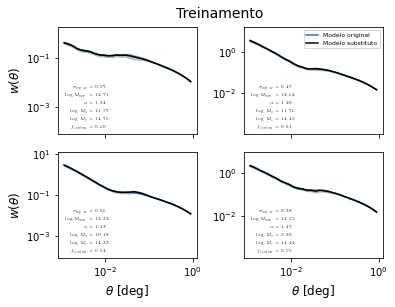

In [13]:
custom_preamble = {
    "text.latex.preamble": [
        r"\usepackage{amsmath}",
        ],
    }
plt.rcParams.update(custom_preamble)

fig, axs = plt.subplots(2, 2, figsize=(6.2, 4.3), sharex=True)
axs = axs.flatten()


for i, par in enumerate(pars[:len(axs)]):
    y_training     = ys_training[i]
    y_training_err = yerrs_training[i]
    y_emulated     = ys_training_emulated[i]
    y_emulated_err = yerrs_training_emulated[i]
    x              = xs_training[0]
    
    ax = axs[i]
    
    ax.set_xscale("log")
    ax.set_yscale("log")
        
    ax.plot(x, y_training, color="tab:blue", label="Modelo original")
    ax.fill_between(x,  np.maximum(y_training-y_training_err, 0.0001), y_training+y_training_err,
                    color="tab:blue", alpha=0.2)
    ax.plot(x, y_emulated, color="k", label="Modelo substituto")
    ax.fill_between(x, y_emulated-y_emulated_err, y_emulated+y_emulated_err, color="k", alpha=0.2)
    
    if ax.is_last_row():
        ax.set_xlabel(r"$\theta$ [deg]", fontsize=12)
    if ax.is_first_col():
        ax.set_ylabel(r"$w(\theta)$", fontsize=12)
    if ax.is_first_row() and ax.is_last_col():
        ax.legend(fontsize=6, loc="upper right");
    
    textstr = '\\\\'.join(((label + " &= %.2f") % (par_)  for label, par_ in zip(labels, par)))      
    textstr = "\\begin{align*}" + textstr + "\\end{align*}"
    
    #props = dict(boxstyle='round', facecolor='tab:red', alpha=0.1)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.45, textstr, transform=ax.transAxes, fontsize=4,
            verticalalignment='top', usetex=True)
    
    ax.set_ylim(10**(np.log10(ax.get_ylim()[0]) - 2.0), 10**(np.log10(ax.get_ylim()[1]) + 0.5))

fig.suptitle('Treinamento', fontsize=14)
fig.tight_layout(rect=(0, 0, 0.9, 0.95))

fig.savefig(plots_dir + "diagnostic_simulated_training.pdf", dpi=600)
fig.savefig(plots_dir + "diagnostic_simulated_training.png", dpi=100)

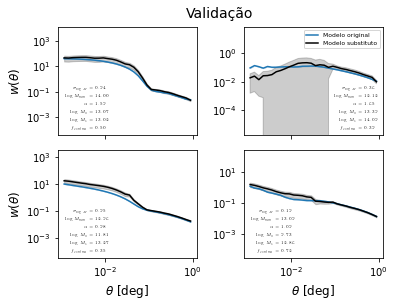

In [14]:
custom_preamble = {
    "text.latex.preamble": [
        r"\usepackage{amsmath}", # for the align enivironment
        #r"\usepackage[euler-digits,small]{eulervm}",
        ],
    }
plt.rcParams.update(custom_preamble)

fig, axs = plt.subplots(2, 2, figsize=(6.2, 4.3), sharex=True)
axs = axs.flatten()


for i, idx in enumerate(np.random.choice(np.arange(pars.shape[0]), len(axs))):
    par = pars[idx]
    y_training     = ys_validation[idx]
    y_training_err = yerrs_validation[idx]
    y_emulated     = ys_validation_emulated[idx]
    y_emulated_err = yerrs_validation_emulated[idx]
    x              = xs_validation[0]
    
    ax = axs[i]
    
    ax.set_xscale("log")
    ax.set_yscale("log")
        
    ax.plot(x, y_training, color="tab:blue", label="Modelo original")
    ax.fill_between(x,  np.maximum(y_training-y_training_err, 0.0001), y_training+y_training_err,
                    color="tab:blue", alpha=0.2)
    ax.plot(x, y_emulated, color="k", label="Modelo substituto")
    ax.fill_between(x, y_emulated-y_emulated_err, y_emulated+y_emulated_err, color="k", alpha=0.2)
    
    if ax.is_last_row():
        ax.set_xlabel(r"$\theta$ [deg]", fontsize=12)
    if ax.is_first_col():
        ax.set_ylabel(r"$w(\theta)$", fontsize=12)
    if ax.is_first_row() and ax.is_last_col():
        ax.legend(fontsize=6, loc="upper right");
    
    textstr = '\\\\'.join(((label + " &= %.2f") % (par_)  for label, par_ in zip(labels, par)))      
    textstr = "\\begin{align*}" + textstr + "\\end{align*}"
    
    #props = dict(boxstyle='round', facecolor='tab:red', alpha=0.1)

    if ax.is_first_row() and ax.is_last_col():
        # place a text box in upper left in axes coords
        ax.text(0.65, 0.45, textstr, transform=ax.transAxes, fontsize=4,
                verticalalignment='top', usetex=True)
    else:
        # place a text box in upper left in axes coords
        ax.text(0.05, 0.45, textstr, transform=ax.transAxes, fontsize=4,
                verticalalignment='top', usetex=True)
    
    ax.set_ylim(10**(np.log10(ax.get_ylim()[0]) - 2.5), 10**(np.log10(ax.get_ylim()[1]) + 2.0))

fig.suptitle('Validação', fontsize=14)
fig.tight_layout(rect=(0, 0, 0.9, 0.95))

fig.savefig(plots_dir + "diagnostic_simulated_validation.pdf", dpi=600)
fig.savefig(plots_dir + "diagnostic_simulated_validation.png", dpi=100)

### Git tags (for notebook)

In [15]:
%%bash

for dir in $(find ../code/ -mindepth 1 -maxdepth 1 -type d -printf "%P\n") ;
do
    pushd ../code/$dir > /dev/null
    echo "$dir: $(git rev-parse HEAD)"
    popd > /dev/null
done

pushd $COSMOSIS_SRC_DIR > /dev/null
echo "cosmosis: $(git rev-parse HEAD)"
pushd $COSMOSIS_SRC_DIR/cosmosis-standard-library > /dev/null
echo "cosmosis-standard-library: $(git rev-parse HEAD)"

__pycache__: 824126a38be8ff1b1ed95aab2fb79b59fb40bdec
hod: 5aae026793e6346e22dfde8a4c9889f805c07130
chain-diagnostics: 212f01c17b4226da0c35fe7e5314e17699f8cc94
jackknife-tools: 739c049f37c02820baa255ca11228538c2661291
halotools-utils: 6b22d1d9ea0a87413e46ecff90cea7065e3c6782
hod-scripting-utils: 9cb4ad2c97dc8a881bd9bf84d9392719d3bcaf45
cosmosis: 14abd2e9ae8d01d0623b223a1fc15babd69a2cd9
cosmosis: 14abd2e9ae8d01d0623b223a1fc15babd69a2cd9
cosmosis-standard-library: bbafc5af7de75f152526ef1e8213449a08956884


bash: /home/pedro/miniconda3/envs/monografia/lib/libtinfo.so.6: no version information available (required by bash)
